## AnoGAN 구현 - Cloud & non-cloud data

- 이미지 사이즈 64
- 채널 수 3


참고한 코드 출처 : https://github.com/mullue/anogan-mnist/blob/master/dcgan%2Banogan.ipynb

이 코드를 참고하여 모델 구조 수정 및 새 데이터 적용


### Module install & import



In [ ]:
pip install -q tensorflow-gpu==2.0.0-rc1

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.0.0-rc1 (from versions: 1.13.1, 1.13.2, 1.14.0, 1.15.0, 1.15.2, 1.15.3, 1.15.4, 1.15.5, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.3.0, 2.3.1, 2.3.2, 2.3.3, 2.3.4, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.4.4, 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.6.4, 2.6.5, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.7.2, 2.7.3, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1)
ERROR: No matching distribution found for tensorflow-gpu==2.0.0-rc1


In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.8.2'

In [ ]:
pip install -q imageio

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [ ]:
from tensorflow.keras.layers import *

### Dataset loading and preparing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/[대학원] 고급통계 프로젝트/data1_cloud

/content/drive/MyDrive/[대학원] 고급통계 프로젝트/data1_cloud


In [ ]:
#Path of cloud and Non-cloud datasets
path_noncloud_train = './noncloud_train/'
path_noncloud_test = './noncloud_test/'
path_cloud = './cloud/'

In [ ]:
from tqdm import tqdm

#Loaded and Preprocessed all the non-cloud satellite images for training
train_images=[]
import os
img_list = os.listdir(path_noncloud_train)
for i in tqdm(img_list):
    img = tf.keras.preprocessing.image.load_img(path_noncloud_train+'/'+str(i), target_size=(64,64,3))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = (img - 31.5) / 31.5 # 이미지 정규화 : -1과 1 사이의 값으로 줄여서 계산을 단순하게
    train_images.append(img)
    
train_images= np.array(train_images)
train_images.shape

100%|██████████| 1400/1400 [00:16<00:00, 84.12it/s] 


(1400, 64, 64, 3)

In [ ]:
from tqdm import tqdm

#Loaded and Preprocessed all the non-cloud satellite images for training
test_images=[]
import os
img_list = os.listdir(path_noncloud_test)
for i in tqdm(img_list):
    img = tf.keras.preprocessing.image.load_img(path_noncloud_test+'/'+str(i), target_size=(64,64,3))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = (img - 31.5) / 31.5
    test_images.append(img)
    
test_images= np.array(test_images)
test_images.shape

100%|██████████| 100/100 [00:00<00:00, 108.57it/s]


(100, 64, 64, 3)

In [ ]:
from tqdm import tqdm

#Loaded and Preprocessed all the non-cloud satellite images for training
cloud_images=[]
import os
img_list = os.listdir(path_cloud)
for i in tqdm(img_list):
    img = tf.keras.preprocessing.image.load_img(path_cloud+'/'+str(i), target_size=(64,64,3))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = (img - 31.5) / 31.5
    cloud_images.append(img)
    
cloud_images= np.array(cloud_images)
cloud_images.shape

100%|██████████| 100/100 [00:00<00:00, 100.64it/s]


(100, 64, 64, 3)

In [ ]:
# train 이미지를 고르게 섞는 것
# bufferSize: shuffle(데이터 섞기)을 하기 위해 필요한 공간의 크기 - 섞을 데이터 개수보다 크게
# batch_size: 한번에 학습할 데이터의 수 (이미지의 수) - 컴퓨터가 감당하지 못하면 줄일 것
BUFFER_SIZE = 1500
BATCH_SIZE = 50

# 데이터 배치를 만들고 섞습니다.
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
print(train_dataset)

<BatchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>


### Model 구조

#### generator
latent variable z로 부터 이미지 사이즈 64x64x3을 생성하기 위한 업샘플링 진행

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4*1024, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Reshape((4, 4, 1024)))

    model.add(layers.Conv2DTranspose(1024, (4, 4), strides=(2, 2), padding='same', use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(512, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(3, (4, 4), strides=(1,1), padding='same', use_bias=False, activation='tanh'))

    return model

In [ ]:
make_generator_model().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 1024)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 1024)       16777216  
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 1024)       4

아직 훈련되지 않은 생성자를 사용하여 이미지 생성해보기

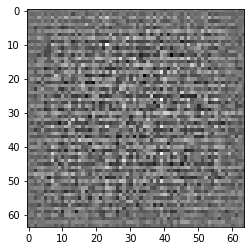

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1,100])
generated_image = generator(noise, training = False)

plt.imshow(generated_image[0,:,:,0], cmap = 'gray')

In [ ]:
print(generated_image.shape)

(1, 64, 64, 3)


#### Discriminator
original CNN 구조를 가진 Discriminator - 진짜/가짜 이미지 분류기

In [ ]:
def make_discriminator_model():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64,(5,5),strides=(2,2), padding='same', input_shape=[64,64,3]))

  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, (5,5), strides = (2,2), padding='same'))
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  return model

In [ ]:
make_discriminator_model().summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        4864      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       204928    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 128)       0         
                                                                 
 flatten (Flatten)           (None, 32768)            

(아직까지 훈련이 되지 않은) 감별자를 사용하여, 생성된 이미지가 진짜인지 가짜인지 판별, 진짜 이미지는 양수값, 가짜 이미지는 음수값 출력

In [ ]:
discriminator = make_discriminator_model()
desicion = discriminator(generated_image) # discriminator 결과로 이상치는 음수, 정상 이미지는 양수로 나와야 한다
print(desicion)

tf.Tensor([[-0.00010766]], shape=(1, 1), dtype=float32)


#### loss function & optimizer

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

- Discriminator loss

In [ ]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output) # 진짜는 진짜로 분류되는지 - 진짜가 1
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) # 가짜는 가짜로 분류되는지 - 가짜가 0
  total_loss = real_loss + fake_loss
  return total_loss

- Generator loss

In [ ]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output) # 가짜를 진짜로 속일 수 있는지

- optimizer of G and D

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### G, D 학습

In [ ]:
def save_models(epoch, discriminator, generator, path='/content'):
    discriminator.save_weights('{}/d-{}.ckpt'.format(path,epoch))
    generator.save_weights('{}/g-{}.ckpt'.format(path,epoch))

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# 이 시드를 시간이 지나도 재활용하겠습니다. 
# (GIF 애니메이션에서 진전 내용을 시각화하는데 쉽기 때문입니다.) 
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# `tf.function`이 어떻게 사용되는지 주목해 주세요.
# 이 데코레이터는 함수를 "컴파일"합니다.
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim]) # z 노이즈 생성

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True) # 노이즈로 가짜 이미지 생성

      real_output = discriminator(images, training=True) # 가짜 이미지
      fake_output = discriminator(generated_images, training=True) # 진짜 이미지

      gen_loss = generator_loss(fake_output) # G의 loss
      disc_loss = discriminator_loss(real_output, fake_output) # D의 loss

    # trainable_variables은 이 모델의 훈련시킬 파라미터
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables) # G의 gradient
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables) # D의 gradient

    # G와 D 최적화
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables)) 
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # GIF를 위한 이미지를 바로 생성합니다.
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # 마지막 에포크가 끝난 후 생성합니다.
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)
  # save weights
  save_models(epochs, discriminator, generator, '/content')

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # `training`이 False로 맞춰진 것을 주목하세요.
  # 이렇게 하면 (배치정규화를 포함하여) 모든 층들이 추론 모드로 실행됩니다. 
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

- model training

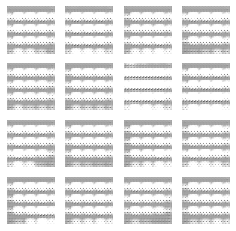

In [ ]:
#%%time
train(train_dataset, EPOCHS)

### 각 이미지에 대한 z 학습
AnoGAN 네트워크를 생성합니다. AnoGAN 네트워크의 정의와 학습은 다음 단계를 거칩니다.



(1) size 100의 임의의 z를 입력받습니다.

(2) 입력된 z는 Dense layer를 지나 generator에 입력하기 위한 latent vector를 생성합니다.

(3) latent vector는 fix된 generator를 거쳐 임의의 이미지를 생성합니다.

(4) 3)의 결과를 입력으로 하여 fix된 Discriminnator를 거쳐 Real/Fake 판단을 위한 feature vector를 생성합니다.

(5) normal/abnormal 판단을 위한 이미지를 이용하여 3), 4)에 대한 Ground truth 값을 생성합니다. (이미지 자체는 3)의 ground truth 역할을 하고, 해당 이미지로부터 Discriminator 연산을 통해 생성한 feature vector는 4)에 대한 ground truth가 됩니다.)

(6) 생성된 (a), (b) 값을 ground truth와 비교하여 2)의 Dense layer를 학습합니다.

(7) 학습과정에서 사용했던 데이터(정상데이터)일 수록 학습이 더 잘 될 것입니다. 이런 원리로 6) training 작업 loss 자체가 abnoaly score 역할을 할 수 있습니다.

AnoGAN 생성시 이전 단계에서 학습된 Generator와 Discriminator 네트워크와 Weight를 로드하여 사용합니다. 아래에서 호출하고 있는 make_discriminator_model()와 make_generator_model()는 앞서 DCGAN학습단계에서 생성한 동일한 함수입니다.

In [ ]:
#Discriminator 로부터 feature 를 도출하는 함수
from tensorflow.keras.models import Model

def feature_extractor(img_shape=(64,64,3)):
    d = make_discriminator_model()
    d.load_weights('/content/d-50.ckpt') #discriminator model weigth 저장된 파일(fixed D)
    intermidiate_model = Model(inputs=d.layers[0].input, outputs=d.layers[-6].output)
    intermidiate_model.compile(loss='binary_crossentropy', optimizer='adam')
    return intermidiate_model

In [ ]:
#임의의 z로부터 latent vector를 생성하고 Generator와 앞서 feature_extractor를 호출합니다.
from tensorflow.keras.layers import Layer, Input, Dense, Flatten

def gne_anogan(loss, latent_dim = 100, channels = 1, img_shape=(64,64,3)):
  g = make_generator_model()
  g.load_weights('/content/g-50.ckpt')
  g.trainable = False # G 고정
  intermidiate_model = feature_extractor(img_shape)
  intermidiate_model.trainable = False # D 고정

  z = Input(shape=(100,)) # z 하나 생성
  gInput = Dense((100))(z) # G(z)
  G_out = g(gInput)
  D_out = intermidiate_model(G_out) # G(z)를 D에 통과시켜
  model = Model(inputs=z, outputs=[G_out, D_out])
  model.compile(loss=sum_of_residual, loss_weights= [0.9, 0.1], optimizer='adam')

  return model

In [ ]:
def sum_of_residual(y_true, y_pred):
    return tf.reduce_sum(abs(y_true - y_pred))

In [ ]:
model = gne_anogan(loss=sum_of_residual)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_6 (Dense)             (None, 100)               10100     
                                                                 
 sequential_4 (Sequential)   (None, 64, 64, 3)         29505024  
                                                                 
 model (Functional)          (None, 32, 32, 64)        4864      
                                                                 
Total params: 29,519,988
Trainable params: 10,100
Non-trainable params: 29,509,888
_________________________________________________________________


- 정상 데이터 테스팅

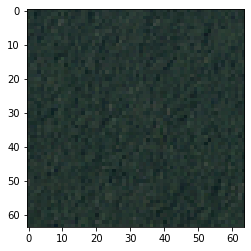

In [ ]:
nimg = train_images[17].reshape(64,64,3) 
plt.figure(figsize=(4,4))
plt.imshow((nimg* 31.5 + 31.5).astype(int))

In [ ]:
%%time
z = np.random.uniform(0, 1, size=(1, 100))
intermidiate_model = feature_extractor(img_shape=(64,64,3))

# ground truth
x = nimg.reshape(1,64,64,3)
d_x = intermidiate_model.predict(x)

# ground truth를 예측하는 z 학습
loss = model.fit(z, [x, d_x], epochs=500, verbose=0)

CPU times: user 9 s, sys: 275 ms, total: 9.28 s
Wall time: 11.2 s


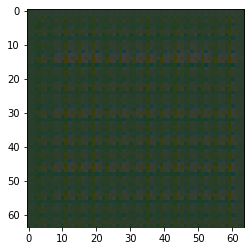

In [ ]:
o1, o2 = model.predict(z)
plt.figure(figsize=(4,4))
plt.imshow((o1.reshape(64,64,3)*31.5+31.5).astype(int))

In [ ]:
loss.history['loss'][-1]

4003.99169921875

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


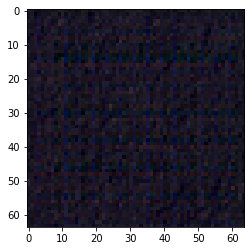

In [ ]:
plt.figure(figsize=(4,4))
plt.imshow(((nimg - o1.reshape(64,64,3))*31.5+31.5).astype(int))

In [ ]:
discriminator = make_discriminator_model()
desicion = discriminator(o1) # discriminator 결과로 이상치는 음수, 정상 이미지는 양수로 나와야 한다
print(desicion)

tf.Tensor([[-0.00347614]], shape=(1, 1), dtype=float32)


- 이상 데이터 테스트

EMNIST에서 임의의 데이터를 선정하여 abnomaly score가 정상에 비해 높게 나오는지 확인

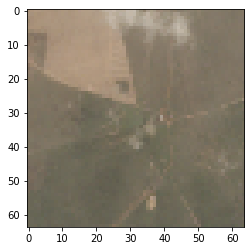

In [ ]:
aimg = cloud_images[2]
plt.figure(figsize=(4,4))
plt.imshow((aimg*31.5+31.5).astype(int))

In [ ]:
%%time
z = np.random.uniform(0, 1, size=(1, 100))
intermidiate_model = feature_extractor(img_shape=(64,64,3))

# ground truth
x = aimg.reshape(1, 64, 64,3)
d_x = intermidiate_model.predict(x)

# ground truth를 예측하는 z 학습
loss_a = model.fit(z, [x, d_x], epochs=500, verbose=0)

CPU times: user 7.93 s, sys: 266 ms, total: 8.2 s
Wall time: 7.74 s


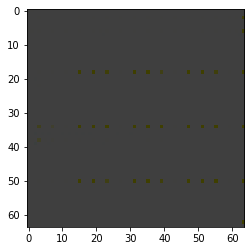

In [ ]:
oa1, oa2 = model.predict(z)
plt.figure(figsize=(4,4))
plt.imshow(((oa1.reshape(64,64,3))*31.5+31.5).astype(int))

In [ ]:
loss_a.history['loss'][-1]

19698.439453125

다음은 residual에 대한 시각적 표현

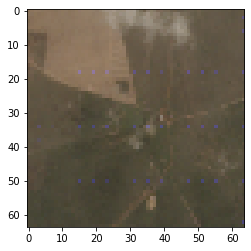

In [ ]:
plt.figure(figsize=(4,4))
plt.imshow(((aimg - oa1.reshape(64,64,3))*31.5+31.5).astype(int))

In [ ]:
discriminator = make_discriminator_model()
desicion = discriminator(oa1) # discriminator 결과로 이상치는 음수, 정상 이미지는 양수로 나와야 한다
print(desicion)

tf.Tensor([[-0.2517554]], shape=(1, 1), dtype=float32)


#### 결과

각 100건의 정상과 비정상 이미지를 이용하여 Anobal loss를 비교

- train 정상 이미지

In [ ]:
nimg_multi = train_images[:100]

In [ ]:
%%time
z = np.random.uniform(0, 1, size=(100, 100))
intermidiate_model = feature_extractor(img_shape=(64,64,3))

# ground truth
x = nimg_multi.reshape(100,64,64,3)
d_x = intermidiate_model.predict(x)

# ground truth를 예측하는 z 학습
loss_normal = model.fit(z, [x, d_x], epochs=500, verbose=0)

CPU times: user 2min 57s, sys: 1.34 s, total: 2min 58s
Wall time: 3min 22s


- test 이상치 이미지

In [ ]:
aimg_multi = cloud_images

In [ ]:
%%time
z = np.random.uniform(0, 1, size=(100, 100))
intermidiate_model = feature_extractor(img_shape=(64,64,3))

# ground truth
x = aimg_multi.reshape(100,64,64,3)
d_x = intermidiate_model.predict(x)

# ground truth를 예측하는 z 학습
loss_abnormal = model.fit(z, [x, d_x], epochs=500, verbose=0)

CPU times: user 2min 55s, sys: 1.37 s, total: 2min 57s
Wall time: 3min 22s


- test 정상 이미지

In [ ]:
test_multi = test_images

In [ ]:
%%time
z = np.random.uniform(0, 1, size=(100, 100))
intermidiate_model = feature_extractor(img_shape=(64,64,3))

# ground truth
x = test_multi.reshape(100,64,64,3)
d_x = intermidiate_model.predict(x)

# ground truth를 예측하는 z 학습
loss_normal_test = model.fit(z, [x, d_x], epochs=500, verbose=0)

CPU times: user 2min 54s, sys: 1.42 s, total: 2min 55s
Wall time: 2min 54s


plot 을 그려 정상 데이터와 비정상 데이터의 loss 값 시각화

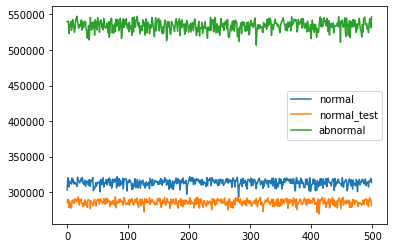

In [ ]:
plt.plot(loss_normal.history['loss'])
plt.plot(loss_normal_test.history['loss'])
plt.plot(loss_abnormal.history['loss'])
plt.legend(['normal','normal_test','abnormal'])
plt.show()

## 결과 - 각 이미지의 loss 확인

#### train data

In [ ]:
train_loss = []
for i in range(100): 
    %%time
    aimg = train_images[i]
    z = np.random.uniform(0, 1, size=(1, 100))
    intermidiate_model = feature_extractor(img_shape=(64,64,3))

    # ground truth
    x = aimg.reshape(1, 64, 64,3)
    d_x = intermidiate_model.predict(x)

    # ground truth를 예측하는 z 학습
    loss_a = model.fit(z, [x, d_x], epochs=200, verbose=0)
    
    train_loss.append(loss_a.history['loss'][-1])

- train data 중 loss가 가장 작은 경우

In [ ]:
aa = np.where(train_loss==np.min(train_loss))[0][0]
aa

54

In [ ]:
train_loss[aa]

2204.248046875

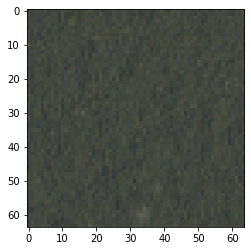

In [ ]:
temp = train_images[aa]
plt.figure(figsize=(4,4))
plt.imshow((temp*31.5+31.5).astype(int))

CPU times: user 7.92 s, sys: 245 ms, total: 8.17 s
Wall time: 7.75 s


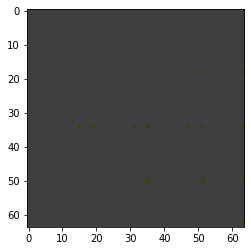

In [ ]:
%%time
z = np.random.uniform(0, 1, size=(1, 100))
intermidiate_model = feature_extractor(img_shape=(64,64,3))

# ground truth
x = temp.reshape(1, 64, 64,3)
d_x = intermidiate_model.predict(x)

# ground truth를 예측하는 z 학습
loss_a = model.fit(z, [x, d_x], epochs=500, verbose=0)

oa1, oa2 = model.predict(z)
plt.figure(figsize=(4,4))
plt.imshow(((oa1.reshape(64,64,3))*31.5+31.5).astype(int))

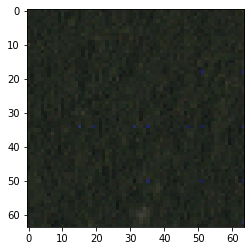

In [ ]:
plt.figure(figsize=(4,4))
plt.imshow(((temp - oa1.reshape(64,64,3))*31.5+31.5).astype(int))

- train data 중 loss가 가장 큰 경우

In [ ]:
aa = np.where(train_loss==np.max(train_loss))[0][0]
aa

28

In [ ]:
train_loss[aa]

37063.22265625

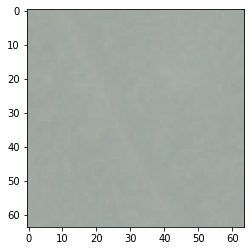

In [ ]:
temp = train_images[aa]
plt.figure(figsize=(4,4))
plt.imshow((temp*31.5+31.5).astype(int))

CPU times: user 7.81 s, sys: 229 ms, total: 8.04 s
Wall time: 7.65 s


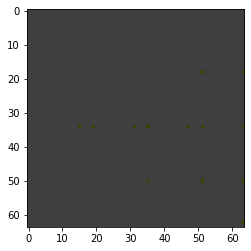

In [ ]:
%%time
z = np.random.uniform(0, 1, size=(1, 100))
intermidiate_model = feature_extractor(img_shape=(64,64,3))

# ground truth
x = temp.reshape(1, 64, 64,3)
d_x = intermidiate_model.predict(x)

# ground truth를 예측하는 z 학습
loss_a = model.fit(z, [x, d_x], epochs=500, verbose=0)

oa1, oa2 = model.predict(z)
plt.figure(figsize=(4,4))
plt.imshow(((oa1.reshape(64,64,3))*31.5+31.5).astype(int))

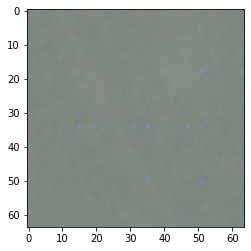

In [ ]:
plt.figure(figsize=(4,4))
plt.imshow(((temp - oa1.reshape(64,64,3))*31.5+31.5).astype(int))

#### test - normal

In [ ]:
test_normal_loss = []
for i in range(100): 
    %%time
    aimg = test_images[i]
    z = np.random.uniform(0, 1, size=(1, 100))
    intermidiate_model = feature_extractor(img_shape=(64,64,3))

    # ground truth
    x = aimg.reshape(1, 64, 64,3)
    d_x = intermidiate_model.predict(x)

    # ground truth를 예측하는 z 학습
    loss_a = model.fit(z, [x, d_x], epochs=200, verbose=0)
    
    test_normal_loss.append(loss_a.history['loss'][-1])

- test 정상 data 중 loss가 가장 작은 경우

In [ ]:
aa = np.where(test_normal_loss==np.min(test_normal_loss))[0][0]
aa

79

In [ ]:
test_normal_loss[aa]

1822.254638671875

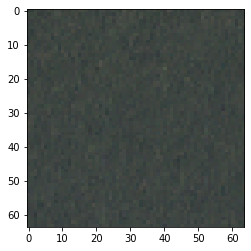

In [ ]:
temp = test_images[aa]
plt.figure(figsize=(4,4))
plt.imshow((temp*31.5+31.5).astype(int))

CPU times: user 7.84 s, sys: 243 ms, total: 8.08 s
Wall time: 10.4 s


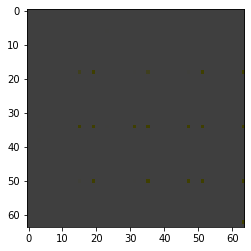

In [ ]:
%%time
z = np.random.uniform(0, 1, size=(1, 100))
intermidiate_model = feature_extractor(img_shape=(64,64,3))

# ground truth
x = temp.reshape(1, 64, 64,3)
d_x = intermidiate_model.predict(x)

# ground truth를 예측하는 z 학습
loss_a = model.fit(z, [x, d_x], epochs=500, verbose=0)

oa1, oa2 = model.predict(z)
plt.figure(figsize=(4,4))
plt.imshow(((oa1.reshape(64,64,3))*31.5+31.5).astype(int))

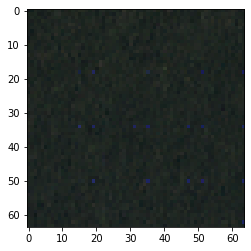

In [ ]:
plt.figure(figsize=(4,4))
plt.imshow(((temp - oa1.reshape(64,64,3))*31.5+31.5).astype(int)) #residual

- test 정상 data 중 loss가 가장 큰 경우

In [ ]:
aa = np.where(test_normal_loss==np.max(test_normal_loss))[0][0]
aa

51

In [ ]:
test_normal_loss[12]

28090.955078125

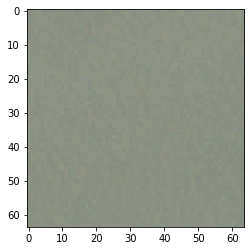

In [ ]:
temp = test_images[12]
plt.figure(figsize=(4,4))
plt.imshow((temp*31.5+31.5).astype(int))

CPU times: user 7.91 s, sys: 251 ms, total: 8.16 s
Wall time: 10.4 s


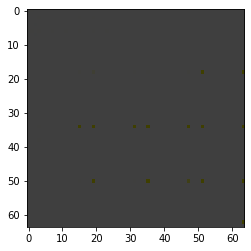

In [ ]:
%%time
z = np.random.uniform(0, 1, size=(1, 100))
intermidiate_model = feature_extractor(img_shape=(64,64,3))

# ground truth
x = temp.reshape(1, 64, 64,3)
d_x = intermidiate_model.predict(x)

# ground truth를 예측하는 z 학습
loss_a = model.fit(z, [x, d_x], epochs=500, verbose=0)

oa1, oa2 = model.predict(z)
plt.figure(figsize=(4,4))
plt.imshow(((oa1.reshape(64,64,3))*31.5+31.5).astype(int))

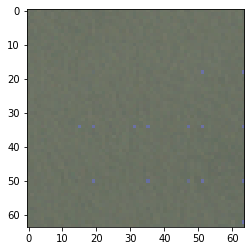

In [ ]:
plt.figure(figsize=(4,4))
plt.imshow(((temp - oa1.reshape(64,64,3))*31.5+31.5).astype(int))

#### test - abnormal

In [ ]:
anomal_loss = []
for i in range(100): 
    %%time
    aimg = cloud_images[i]
    z = np.random.uniform(0, 1, size=(1, 100))
    intermidiate_model = feature_extractor(img_shape=(64,64,3))

    # ground truth
    x = aimg.reshape(1, 64, 64,3)
    d_x = intermidiate_model.predict(x)

    # ground truth를 예측하는 z 학습
    loss_a = model.fit(z, [x, d_x], epochs=200, verbose=0)
    
    anomal_loss.append(loss_a.history['loss'][-1])

- test 이상치 data 중 loss가 가장 작은 경우

In [ ]:
aa = np.where(anomal_loss==np.min(anomal_loss))[0][0]
aa

26

In [ ]:
anomal_loss[aa]

2756.25146484375

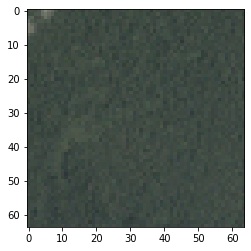

In [ ]:
temp = cloud_images[aa]
plt.figure(figsize=(4,4))
plt.imshow((temp*31.5+31.5).astype(int))

CPU times: user 8.01 s, sys: 241 ms, total: 8.25 s
Wall time: 7.8 s


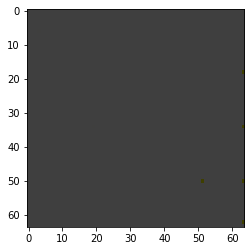

In [ ]:
%%time
z = np.random.uniform(0, 1, size=(1, 100))
intermidiate_model = feature_extractor(img_shape=(64,64,3))

# ground truth
x = temp.reshape(1, 64, 64,3)
d_x = intermidiate_model.predict(x)

# ground truth를 예측하는 z 학습
loss_a = model.fit(z, [x, d_x], epochs=500, verbose=0)

oa1, oa2 = model.predict(z)
plt.figure(figsize=(4,4))
plt.imshow(((oa1.reshape(64,64,3))*31.5+31.5).astype(int))

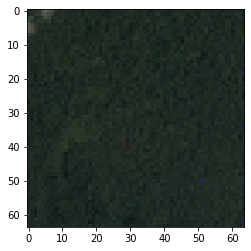

In [ ]:
plt.figure(figsize=(4,4))
plt.imshow(((temp - oa1.reshape(64,64,3))*31.5+31.5).astype(int))

- test 이상치 data 중 loss가 가장 큰 경우

In [ ]:
aa = np.where(anomal_loss==np.max(anomal_loss))[0][0]
aa

78

In [ ]:
test_normal_loss[aa]

10777.7958984375

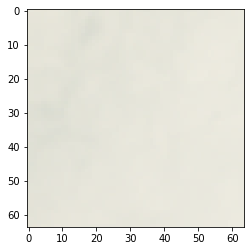

In [ ]:
temp = cloud_images[aa]
plt.figure(figsize=(4,4))
plt.imshow((temp*31.5+31.5).astype(int))

CPU times: user 7.82 s, sys: 262 ms, total: 8.08 s
Wall time: 10.5 s


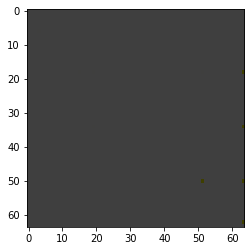

In [ ]:
%%time
z = np.random.uniform(0, 1, size=(1, 100))
intermidiate_model = feature_extractor(img_shape=(64,64,3))

# ground truth
x = temp.reshape(1, 64, 64,3)
d_x = intermidiate_model.predict(x)

# ground truth를 예측하는 z 학습
loss_a = model.fit(z, [x, d_x], epochs=500, verbose=0)

oa1, oa2 = model.predict(z)
plt.figure(figsize=(4,4))
plt.imshow(((oa1.reshape(64,64,3))*31.5+31.5).astype(int))

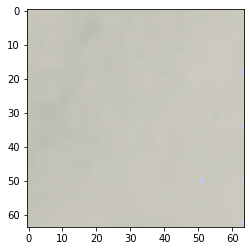

In [ ]:
plt.figure(figsize=(4,4))
plt.imshow(((temp - oa1.reshape(64,64,3))*31.5+31.5).astype(int))

#### summary - all result

No handles with labels found to put in legend.


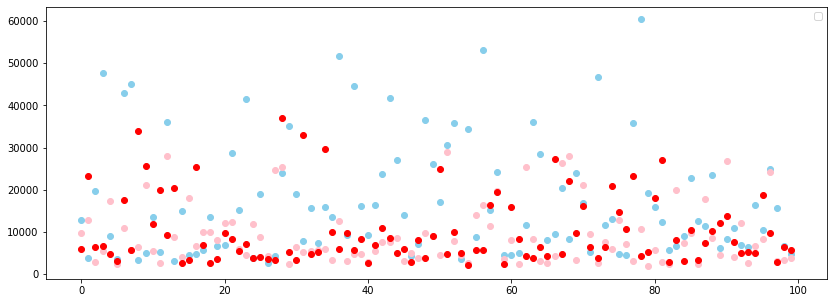

In [ ]:
from matplotlib import pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5
plt.scatter(range(100), anomal_loss, c='skyblue') #skyblue는 anomal
plt.scatter(range(100), test_normal_loss, c='pink') #pink는 test normal
plt.scatter(range(100), train_loss, c='red') #red는 train
plt.legend()

No handles with labels found to put in legend.


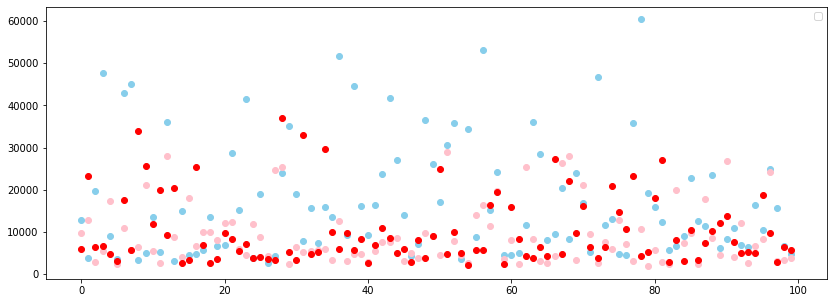

In [ ]:
from matplotlib import pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5
plt.scatter(range(100), anomal_loss, c='skyblue') #skyblue는 anomal
plt.scatter(range(100), test_normal_loss, c='pink') #pink는 test normal
plt.scatter(range(100), train_loss, c='red') #red는 train
plt.legend()

In [ ]:
y_test = np.concatenate([np.zeros(shape=(100,), dtype=np.int8), np.ones(shape=(100,), dtype=np.int8), np.ones(shape=(100,), dtype=np.int8)*2])

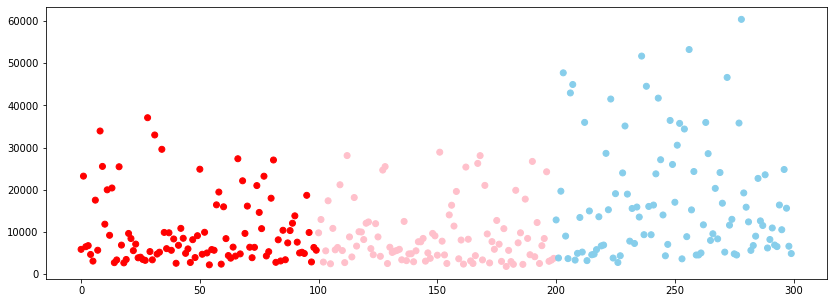

In [ ]:
from matplotlib import pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5
plt.scatter(range(300), np.concatenate([train_loss, test_normal_loss, anomal_loss]), c=['red' if x == 0 else 'pink' if x==1 else 'skyblue' for x in y_test]) #skyblue는 anomal

빨간색이 train, 분홍색이 test 정상, 하늘색이 test 이상치 이미지이다. 각 그룹별 loss를 비교할 수 있다.